Importation des bibliothèques

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from nltk.corpus import stopwords
import string


In [34]:
#Récupération des données
df=pd.read_csv("movies2023.csv")
df.head(10)

,MovieID,Title,Popularity,Overview,Genres,Actors,Directors,VoteAverage,ReleaseYear
0,695721,The Hunger Games: The Ballad of Songbirds & Sn...,2222.913,64 years before he becomes the tyrannical pres...,"Drama, Science Fiction, Action","Tom Blyth, Rachel Zegler, Peter Dinklage, Jaso...",Francis Lawrence,7.274,2023.0
1,572802,Aquaman and the Lost Kingdom,1928.895,"Black Manta, still driven by the need to aveng...","Action, Adventure, Fantasy","Jason Momoa, Patrick Wilson, Amber Heard, Yahy...",James Wan,6.500,2023.0
2,1029575,The Family Plan,1463.554,"Dan Morgan is many things: a devoted husband, ...","Action, Comedy","Mark Wahlberg, Michelle Monaghan, Maggie Q, Zo...",Simon Cellan Jones,7.535,2023.0
3,787699,Wonka,950.379,Willy Wonka – chock-full of ideas and determin...,"Comedy, Family, Fantasy","Timothée Chalamet, Calah Lane, Keegan-Michael ...",Paul King,7.224,2023.0
4,520758,Chicken Run: Dawn of the Nugget,806.226,A band of fearless chickens flock together to ...,"Animation, Adventure, Comedy, Family","Thandiwe Newton, Zachary Levi, Bella Ramsey, I...",Sam Fell,7.662,2023.0
5,1118595,The Jester,774.445,A malevolent being known as The Jester terrori...,"Horror, Thriller, Mystery","Matt Servitto, Lelia Symington, Delaney White,...",Colin Krawchuk,6.015,2023.0
6,1071215,Thanksgiving,699.856,"After a Black Friday riot ends in tragedy, a m...","Horror, Thriller, Mystery","Patrick Dempsey, Nell Verlaque, Addison Rae, J...",Eli Roth,6.667,2023.0
7,891699,Silent Night,678.542,A tormented father witnesses his young son die...,"Action, Crime","Joel Kinnaman, Kid Cudi, Harold Torres, Catali...",John Woo,5.900,2023.0
8,901362,Trolls Band Together,608.676,"When Branch's brother, Floyd, is kidnapped for...","Animation, Family, Music, Fantasy, Comedy","Anna Kendrick, Justin Timberlake, Camila Cabel...",Walt Dohrn,7.140,2023.0
9,872585,Oppenheimer,601.492,The story of J. Robert Oppenheimer's role in t...,"Drama, History","Cillian Murphy, Emily Blunt, Matt Damon, Rober...",Christopher Nolan,8.129,2023.0


Visualisation des données

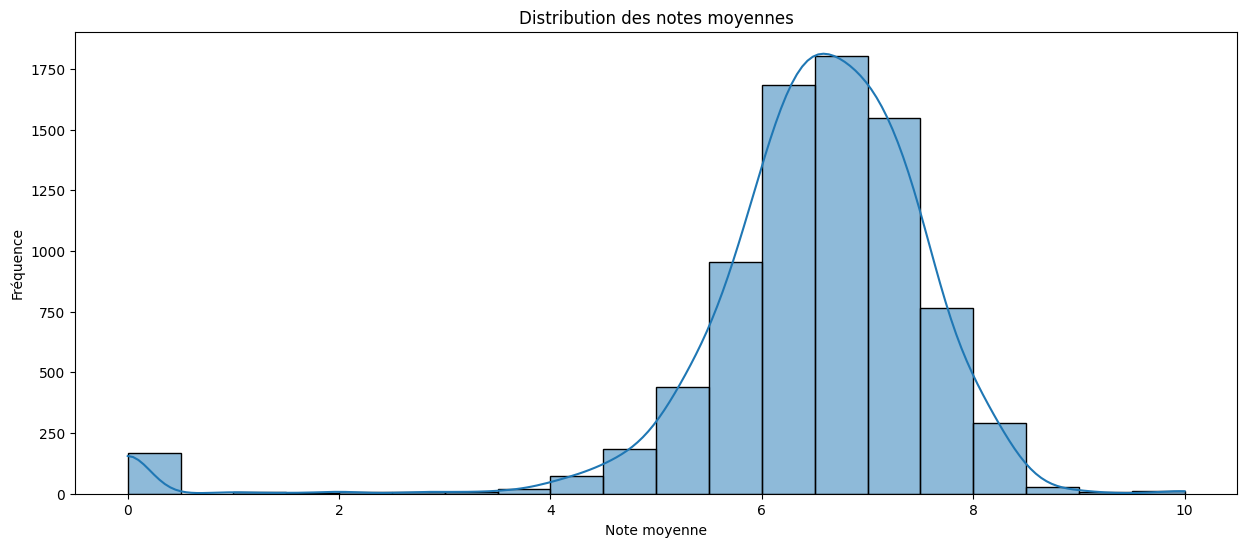

In [3]:
# Histogramme des notes moyennes
plt.figure(figsize=(15, 6))
sns.histplot(df['VoteAverage'], bins=20, kde=True)
plt.title('Distribution des notes moyennes')
plt.xlabel('Note moyenne')
plt.ylabel('Fréquence')
plt.show()

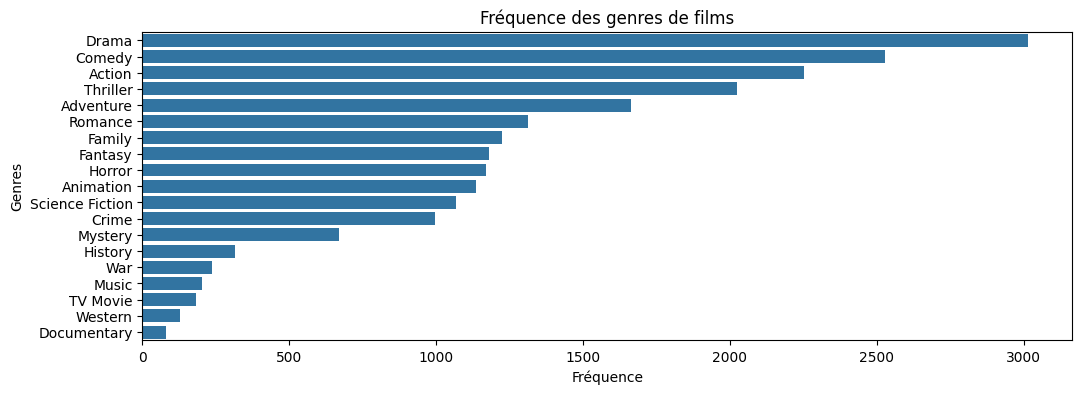

In [4]:
# Diagramme à barres pour les genres de films
plt.figure(figsize=(12, 4))
genre_counts = df['Genres'].str.strip().str.split(',').explode().str.strip().value_counts()
sns.barplot(x=genre_counts.values, y=genre_counts.index)
plt.title('Fréquence des genres de films')
plt.xlabel('Fréquence')
plt.ylabel('Genres')
plt.show()

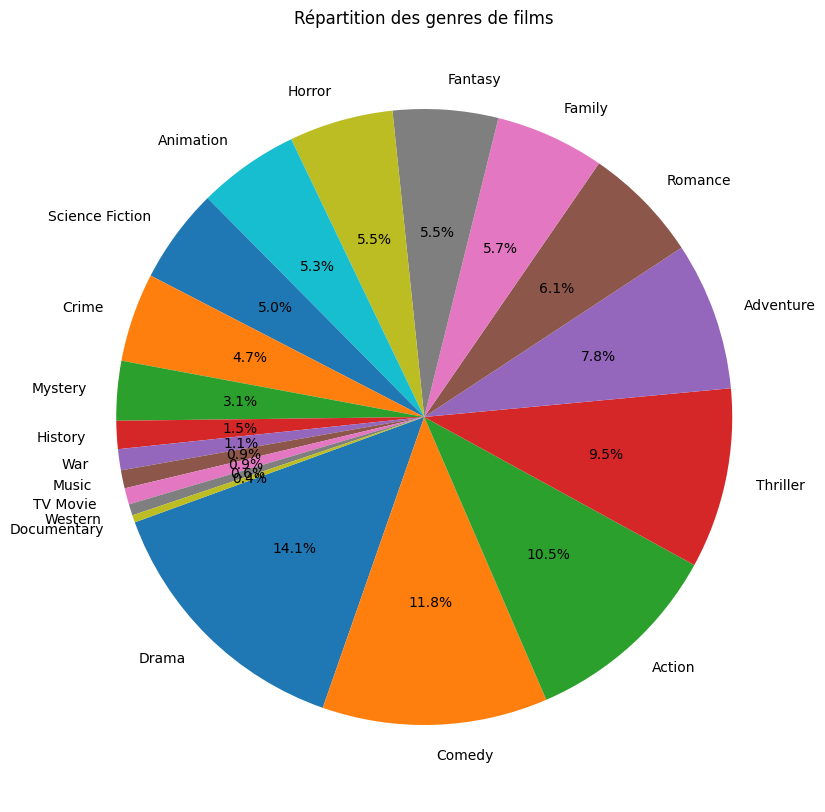

In [5]:
# Afficher le diagramme à secteurs
plt.figure(figsize=(18, 10))
plt.pie(genre_counts, labels=genre_counts.index, autopct='%1.1f%%', startangle=200)
plt.title('Répartition des genres de films')
plt.show()

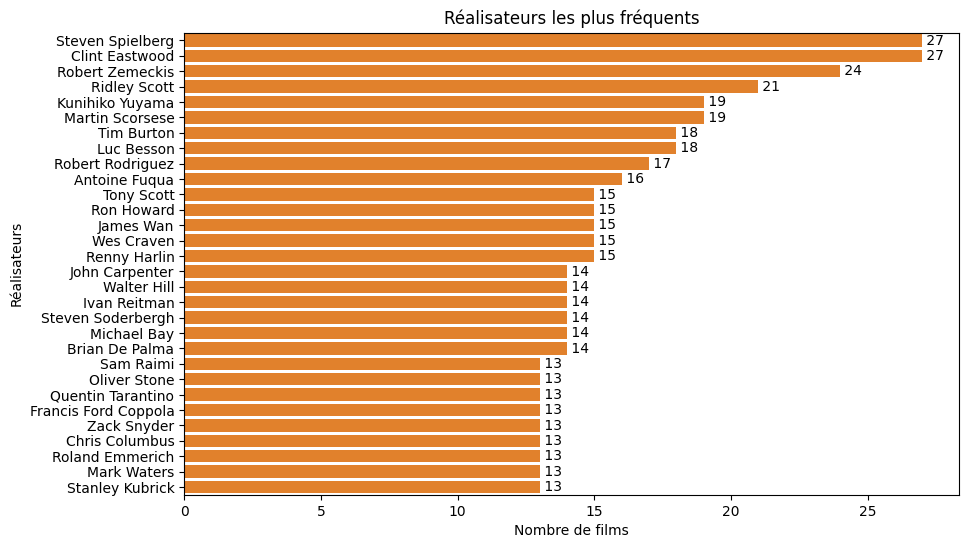

In [6]:
# Afficher le graphique à barres des réalisateurs les plus fréquents et compter leur fréquence
plt.figure(figsize=(10, 6))
director_counts = df['Directors'].str.strip().value_counts().head(30)
sns.barplot(x=director_counts.values, y=director_counts.index)
bar_plot = sns.barplot(x=director_counts.values, y=director_counts.index)
plt.title('Réalisateurs les plus fréquents')
plt.xlabel('Nombre de films')
plt.ylabel('Réalisateurs')
# Afficher les valeurs exactes à côté des barres
for index, value in enumerate(director_counts.values):
    bar_plot.text(value, index, f' {value}', ha='left', va='center')
plt.show()

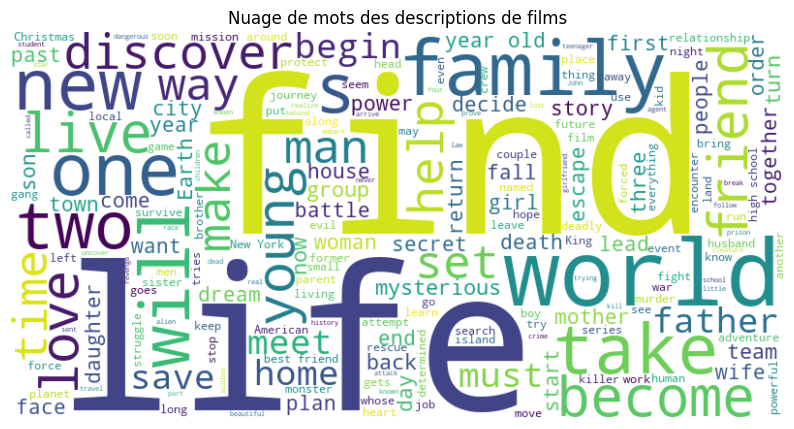

In [7]:
# Concaténer toutes les descriptions de films
text = ' '.join(df['Overview'].fillna(''))
# Créer et afficher le nuage de mots
wordcloud = WordCloud(width=800, height=400, max_words=200, background_color='white').generate(text)
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nuage de mots des descriptions de films')
plt.show()

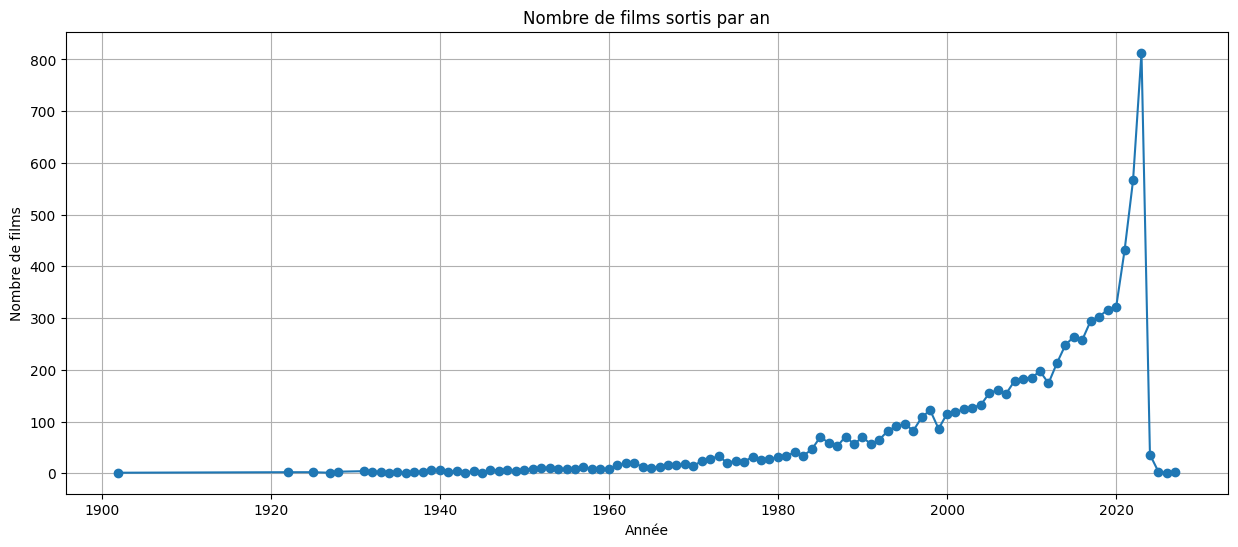

In [8]:
# Convertir la colonne ReleaseYear en datetime et compter les sorties par année
df['ReleaseYear'] = pd.to_datetime(df['ReleaseYear'], format='%Y')
yearly_counts = df['ReleaseYear'].dt.year.value_counts().sort_index()
# Afficher le graphique temporel
plt.figure(figsize=(15, 6))
yearly_counts.plot(marker='o')
plt.title('Nombre de films sortis par an')
plt.xlabel('Année')
plt.ylabel('Nombre de films')
plt.grid(True)
plt.show()

Préprocessing

In [9]:
# Compter les valeurs manquantes par colonne
missing_values_count = df.isna().sum()
# Afficher les colonnes avec des valeurs manquantes et leur décompte respectif
print(missing_values_count[missing_values_count > 0])


Overview       21
Genres         24
Actors         21
Directors      29
ReleaseYear     9
dtype: int64


In [10]:
# Identifier les lignes avec des valeurs manquantes
rows_with_missing_values = df[df.isnull().any(axis=1)]
# Afficher les lignes où il y a au moins une valeur manquante
rows_with_missing_values


,MovieID,Title,Popularity,Overview,Genres,Actors,Directors,VoteAverage,ReleaseYear
64,1206029,"Muchachos, la película de la gente",219.141,NaN,Documentary,Guillermo Francella,Jesús Braceras,6.7,2023-01-01
173,1156593,Your Fault,113.528,NaN,"Drama, Romance","Nicole Wallace, Gabriel Guevara",Domingo González,0.0,NaT
386,1211814,Trees and Other Entanglements,78.785,"A poetic meditation on nature, mortality, and ...",Documentary,NaN,Irene Taylor Brodsky,6.5,2023-01-01
429,1211814,Trees and Other Entanglements,78.785,"A poetic meditation on nature, mortality, and ...",Documentary,NaN,Irene Taylor Brodsky,6.5,2023-01-01
460,107406,Oscenità,69.901,NaN,Drama,"Isarco Ravaioli, Mirella Rossi, Dino Strano, B...",Renato Polselli,7.3,1980-01-01
...,...,...,...,...,...,...,...,...,...
7615,585534,Morning Moon Is Cruel,15.029,NaN,Drama,"Mio Takaki, Junnosuke Saitô, Tsunehiko Watase,...",Masanori Watanabe,5.0,1981-01-01
7754,1200334,A Little Gay,24.594,A sister comes home for the holidays and walks...,NaN,"Kyle Prue, Eric Goodwin, Lanie Christensen, Wa...",Lanie Christensen,0.0,2023-01-01
7771,553301,Your Name,14.857,Two teenagers discover they are magically and ...,"Drama, Fantasy, Romance",NaN,Carlos López Estrada,0.0,NaT
7819,1212326,Die Helene Fischer Show 2023,17.490,NaN,Music,Helene Fischer,NaN,0.0,2023-01-01


In [11]:
# Supprimer les lignes avec des valeurs manquantes
df.dropna(inplace=True)
# Réinitialiser les index
df.reset_index(drop=True, inplace=True)
# Compter les valeurs manquantes par colonne
missing_values_count = df.isna().sum()
# Afficher les colonnes avec des valeurs manquantes et leur décompte respectif
print(missing_values_count[missing_values_count > 0])
# Afficher la forme du DataFrame après la suppression et la réinitialisation des index
print(df.shape)

Series([], dtype: int64)
(7927, 9)


In [12]:
# Compter le nombre d'occurrences de chaque titre
movie_counts = df['MovieID'].value_counts()
# Filtrer les titres qui apparaissent plus d'une fois
duplicated_movies = movie_counts[movie_counts > 1]
# Afficher le nombre de titres qui apparaissent plus d'une fois
print(f"Nombre de films apparaissant plus d'une fois : {len(duplicated_movies)}")
duplicated_movies


Nombre de films apparaissant plus d'une fois : 1541


MovieID
76        4
10281     4
247849    4
9441      4
2675      4
         ..
9016      2
19404     2
20453     2
893694    2
164052    2
Name: count, Length: 1541, dtype: int64

In [13]:
# Supprimer les duplicatas dans la colonne 'MovieID'
df.drop_duplicates(subset='MovieID', keep='first', inplace=True)
# Réinitialiser les index
df.reset_index(drop=True, inplace=True)


In [14]:
# Compter le nombre d'occurrences de chaque titre
movie_counts = df['MovieID'].value_counts()
# Filtrer les titres qui apparaissent plus d'une fois
duplicated_movies = movie_counts[movie_counts > 1]
# Afficher le nombre de titres qui apparaissent plus d'une fois
print(f"Nombre de films apparaissant plus d'une fois : {len(duplicated_movies)}")
duplicated_movies

Nombre de films apparaissant plus d'une fois : 0


Series([], Name: count, dtype: int64)

In [15]:
# Afficher la forme du DataFrame après la suppression des doublons
print(df.shape)

(6236, 9)


In [16]:
non_numeric_columns = df.select_dtypes(exclude=['number']).columns.tolist()
print("Colonnes non numériques :", non_numeric_columns)

Colonnes non numériques : ['Title', 'Overview', 'Genres', 'Actors', 'Directors', 'ReleaseYear']


In [17]:
df['ReleaseYear'] = pd.to_numeric(df['ReleaseYear'])
df.head(2)

,MovieID,Title,Popularity,Overview,Genres,Actors,Directors,VoteAverage,ReleaseYear
0,695721,The Hunger Games: The Ballad of Songbirds & Sn...,2222.913,64 years before he becomes the tyrannical pres...,"Drama, Science Fiction, Action","Tom Blyth, Rachel Zegler, Peter Dinklage, Jaso...",Francis Lawrence,7.274,1672531200000000000
1,572802,Aquaman and the Lost Kingdom,1928.895,"Black Manta, still driven by the need to aveng...","Action, Adventure, Fantasy","Jason Momoa, Patrick Wilson, Amber Heard, Yahy...",James Wan,6.500,1672531200000000000


Elaboration des matrices

In [18]:
# Sélectionner uniquement les colonnes pertinentes pour le modèle
selected_columns = ['MovieID', 'Genres', 'Actors', 'Directors', 'VoteAverage', 'ReleaseYear']  # Colonnes sélectionnées
df_selected = df[selected_columns].copy()
df_selected

,MovieID,Genres,Actors,Directors,VoteAverage,ReleaseYear
0,695721,"Drama, Science Fiction, Action","Tom Blyth, Rachel Zegler, Peter Dinklage, Jaso...",Francis Lawrence,7.274,1672531200000000000
1,572802,"Action, Adventure, Fantasy","Jason Momoa, Patrick Wilson, Amber Heard, Yahy...",James Wan,6.500,1672531200000000000
2,1029575,"Action, Comedy","Mark Wahlberg, Michelle Monaghan, Maggie Q, Zo...",Simon Cellan Jones,7.535,1672531200000000000
3,787699,"Comedy, Family, Fantasy","Timothée Chalamet, Calah Lane, Keegan-Michael ...",Paul King,7.224,1672531200000000000
4,520758,"Animation, Adventure, Comedy, Family","Thandiwe Newton, Zachary Levi, Bella Ramsey, I...",Sam Fell,7.662,1672531200000000000
...,...,...,...,...,...,...
6231,15143,"Drama, Romance","Eric Stoltz, Mary Stuart Masterson, Lea Thomps...",Howard Deutch,6.900,536457600000000000
6232,16392,"Action, Thriller","Nathan Phillips, Nadia Bjorlin, Eddie Griffin,...",Andy Cheng,5.000,1167609600000000000
6233,5203,"Romance, Drama","Jacqueline Bisset, Carré Otis, Mickey Rourke, ...",Zalman King,5.236,599616000000000000
6234,93837,"Action, Comedy","Miley Cyrus, Jeremy Piven, Mike O'Malley, Josh...",Tom Vaughan,6.160,1325376000000000000


In [19]:
# Convertir les colonnes catégoriques en listes pour le One-Hot Encoding
df_selected['Genres'] = df_selected['Genres'].apply(lambda x: x.split(','))
df_selected['Actors'] = df_selected['Actors'].apply(lambda x: x.split(','))
df_selected['Directors'] = df_selected['Directors'].apply(lambda x: [x])

# Appliquer le One-Hot Encoding pour les Genres, Acteurs et Réalisateurs
mlb_genres = MultiLabelBinarizer()
mlb_actors = MultiLabelBinarizer()
mlb_directors = MultiLabelBinarizer()

encoded_genres = pd.DataFrame(mlb_genres.fit_transform(df_selected['Genres']), columns=mlb_genres.classes_, index=df_selected.index)
encoded_actors = pd.DataFrame(mlb_actors.fit_transform(df_selected['Actors']), columns=mlb_actors.classes_, index=df_selected.index)
encoded_directors = pd.DataFrame(mlb_directors.fit_transform(df_selected['Directors']), columns=mlb_directors.classes_, index=df_selected.index)

# Concaténer les DataFrames encodés avec df_selected
df_final = pd.concat([df_selected.drop(['Genres', 'Actors', 'Directors'], axis=1), encoded_genres, encoded_actors, encoded_directors], axis=1)
df_final


,MovieID,VoteAverage,ReleaseYear,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,...,Zoya Akhtar,Zu Quirke,loundraw,"Àlex Pastor, David Pastor",Álex de la Iglesia,Álvaro Fernández Armero,Ángel Gómez Hernández,Ángel Manuel Soto,Árni Ólafur Ásgeirsson,Óskar Thór Axelsson
0,695721,7.274,1672531200000000000,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,572802,6.500,1672531200000000000,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1029575,7.535,1672531200000000000,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,787699,7.224,1672531200000000000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,520758,7.662,1672531200000000000,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6231,15143,6.900,536457600000000000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6232,16392,5.000,1167609600000000000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6233,5203,5.236,599616000000000000,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
6234,93837,6.160,1325376000000000000,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
# Normalisation des données
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_final)
# Réduction de dimensionnalité avec PCA
pca = PCA(n_components=200)  # Réduisez le nombre de composants selon vos besoins
df_reduced = pca.fit_transform(scaled_data)


In [21]:
# Calcul de la similarité cosinus entre les articles réduits
article_similarity = cosine_similarity(df_reduced, df_reduced)
# Affichage des similarités
article_similarity

array([[ 1.        ,  0.04388551, -0.10901402, ...,  0.07822894,
         0.13816911,  0.12310774],
       [ 0.04388551,  1.        ,  0.06722658, ...,  0.41719295,
         0.04993829,  0.48969634],
       [-0.10901402,  0.06722658,  1.        , ...,  0.22683238,
         0.02674684,  0.18400304],
       ...,
       [ 0.07822894,  0.41719295,  0.22683238, ...,  1.        ,
         0.19842363,  0.88112631],
       [ 0.13816911,  0.04993829,  0.02674684, ...,  0.19842363,
         1.        ,  0.17518064],
       [ 0.12310774,  0.48969634,  0.18400304, ...,  0.88112631,
         0.17518064,  1.        ]])

In [22]:
# Supposons que nous avons une matrice de similarité entre les films
num_movies = article_similarity.shape[0]
# Générer des prédictions factices pour les scores des utilisateurs
predicted_ratings = np.random.rand(num_movies, num_movies) * 5 # Échelle de notation de 0 à 5, par exemple
# Calculer l'erreur quadratique moyenne (RMSE)
rmse = mean_squared_error(article_similarity, predicted_ratings, squared=False)
print(f"RMSE: {rmse}")

RMSE: 2.743238421154878


In [23]:
def get_recommendations_based_on_genre(genre, article_similarity, num_recommendations=5):
    # Trouver les films similaires en fonction du genre donné
    genre_indices = df[df['Genres'].apply(lambda x: genre in x)]
    recommendations = genre_indices.index.tolist()
    return recommendations[:num_recommendations]

def get_recommendations_based_on_actor(actor, article_similarity, num_recommendations=5):
    # Trouver les films similaires en fonction de l'acteur donné
    actor_indices = df[df['Actors'].apply(lambda x: actor in x)]
    recommendations = actor_indices.index.tolist()
    return recommendations[:num_recommendations]

def get_recommendations_based_on_director(director, article_similarity, num_recommendations=5):
    # Trouver les films similaires en fonction du réalisateur donné
    director_indices = df[df['Directors'].apply(lambda x: director in x)]
    recommendations = director_indices.index.tolist()
    return recommendations[:num_recommendations]

def get_movie_titles(indices):
    return df.iloc[indices]['Title'].tolist()

# Récupérer des recommandations basées sur le genre
genre = 'Adventure'
recommendations_genre = get_recommendations_based_on_genre(genre, article_similarity)
#print(f"Recommandations pour le genre '{genre}': {recommendations_genre}")
titles_genre = get_movie_titles(recommendations_genre)
print(f"Titres recommandés pour le genre '{genre}': {titles_genre}")

# Récupérer des recommandations basées sur l'acteur
actor = 'Daniel Radcliffe'
recommendations_actor = get_recommendations_based_on_actor(actor, article_similarity)
#print(f"Recommandations pour l'acteur '{actor}': {recommendations_actor}")
titles_actor = get_movie_titles(recommendations_actor)
print(f"Titres recommandés pour l'acteur '{actor}': {titles_actor}")
# Récupérer des recommandations basées sur le réalisateur
director = 'Steven Spielberg'
recommendations_director = get_recommendations_based_on_director(director, article_similarity)
#print(f"Recommandations pour le réalisateur '{director}': {recommendations_director}")
titles_director = get_movie_titles(recommendations_director)
print(f"Titres recommandés pour le réalisateur '{director}': {titles_director}")


Titres recommandés pour le genre 'Adventure': ['Aquaman and the Lost Kingdom', 'Chicken Run: Dawn of the Nugget', 'Rebel Moon - Part One: A Child of Fire', 'Expend4bles', 'Barbie']
Titres recommandés pour l'acteur 'Daniel Radcliffe': ["Harry Potter and the Philosopher's Stone", 'Harry Potter and the Chamber of Secrets', 'Harry Potter and the Goblet of Fire', 'Harry Potter and the Prisoner of Azkaban', 'Harry Potter and the Deathly Hallows: Part 1']
Titres recommandés pour le réalisateur 'Steven Spielberg': ["Schindler's List", 'Saving Private Ryan', 'Indiana Jones and the Kingdom of the Crystal Skull', 'Indiana Jones and the Temple of Doom', 'Catch Me If You Can']


In [24]:
# Création d'une nouvelle colonne 'Description' avec la concaténation des colonnes pertinentes
df['Description'] = df['Overview'] + ' ' + df['Actors'] + ' ' + df['Directors'] + ' ' + df['Genres']

# Sélection des colonnes nécessaires pour le nouveau DataFrame
new_df = df[['MovieID', 'Title', 'Description']].copy()
new_df

,MovieID,Title,Description
0,695721,The Hunger Games: The Ballad of Songbirds & Sn...,64 years before he becomes the tyrannical pres...
1,572802,Aquaman and the Lost Kingdom,"Black Manta, still driven by the need to aveng..."
2,1029575,The Family Plan,"Dan Morgan is many things: a devoted husband, ..."
3,787699,Wonka,Willy Wonka – chock-full of ideas and determin...
4,520758,Chicken Run: Dawn of the Nugget,A band of fearless chickens flock together to ...
...,...,...,...
6231,15143,Some Kind of Wonderful,"A young tomboy, Watts, finds her feelings for ..."
6232,16392,Redline,A gorgeous young automobile fanatic--and front...
6233,5203,Wild Orchid,A woman lawyer becomes mesmerized by a self-ma...
6234,93837,So Undercover,When the FBI hires her to go undercover at a c...


In [25]:
# Liste des stopwords en anglais
stop_words = set(stopwords.words('english'))
# Fonction pour prétraiter le texte
def preprocess_text(text):
    # Convertir le texte en minuscules
    text = text.lower()
    # Supprimer la ponctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Tokenization
    tokens = text.split()
    # Supprimer les stopwords
    tokens = [word for word in tokens if word not in stop_words]
    # Reconstruire le texte traité
    processed_text = ' '.join(tokens)
    return processed_text
# Appliquer le prétraitement aux descriptions
new_df['Processed_Description'] = new_df['Description'].apply(preprocess_text)
# Initialisation de CountVectorizer avec le traitement des données (stopwords, etc.)
vectorizer = CountVectorizer()
# Transformer les descriptions prétraitées en une matrice de compte de mots
description_matrix = vectorizer.fit_transform(new_df['Processed_Description'])
# Calcul de la similarité cosinus entre les descriptions
description_similarity = cosine_similarity(description_matrix, description_matrix)
description_similarity


array([[1.        , 0.03086067, 0.04930066, ..., 0.0428993 , 0.04748357,
        0.04562573],
       [0.03086067, 1.        , 0.06390097, ..., 0.02780192, 0.03692745,
        0.02956885],
       [0.04930066, 0.06390097, 1.        , ..., 0.03806935, 0.02528249,
        0.03036661],
       ...,
       [0.0428993 , 0.02780192, 0.03806935, ..., 1.        , 0.        ,
        0.03082766],
       [0.04748357, 0.03692745, 0.02528249, ..., 0.        , 1.        ,
        0.        ],
       [0.04562573, 0.02956885, 0.03036661, ..., 0.03082766, 0.        ,
        1.        ]])

In [26]:
# Supposons que nous avons une matrice de similarité entre les films
num_movies = description_similarity.shape[0]
# Générer des prédictions factices pour les scores des utilisateurs
predicted_ratings3 = np.random.rand(num_movies, num_movies) * 5 # Échelle de notation de 0 à 5, par exemple
# Calculer l'erreur quadratique moyenne (RMSE)
rmse = mean_squared_error(description_similarity, predicted_ratings3, squared=False)
print(f"RMSE: {rmse}")

RMSE: 2.8555216888728756


In [27]:
def get_movie_recommendations_by_title(movie_title, df, description_similarity, num_recommendations=5):
    # Trouver l'index du film dans le DataFrame
    movie_index = df[df['Title'] == movie_title].index[0]
    
    # Obtenir les indices des films similaires pour le film donné
    similar_movies = sorted(list(enumerate(description_similarity[movie_index])), key=lambda x: x[1], reverse=True)
    
    # Récupérer les titres des films recommandés
    recommended_movie_indices = [movie[0] for movie in similar_movies[1:num_recommendations+1]]  # Exclut le film lui-même
    recommended_movies = df.iloc[recommended_movie_indices]['Title'].tolist()
    
    return recommended_movies

# Exemple : obtenir des recommandations pour un titre de film spécifique
movie_title = 'Chicken Run: Dawn of the Nugget'  # Remplacez par le titre du film pour lequel vous voulez des recommandations
num_recommendations = 10  # Nombre de recommandations à générer
recommendations = get_movie_recommendations_by_title(movie_title, new_df, description_similarity, num_recommendations)

# Afficher les recommandations
print(f"Recommandations pour le film '{movie_title}': {recommendations}")


Recommandations pour le film 'Chicken Run: Dawn of the Nugget': ['Flushed Away', 'Chicken Run', 'Bambi', 'Merry Madagascar', 'Straw Dogs', 'Harry Potter and the Chamber of Secrets', 'Harry Potter and the Deathly Hallows: Part 1', 'The Pirates! In an Adventure with Scientists!', 'The Boss Baby: Family Business', 'Madagascar: Escape 2 Africa']


In [28]:
# Enregistrement de la matrice de similarité dans un fichier
np.save('article_similarity.npy', article_similarity)
# Enregistrement de la matrice de similarité dans un fichier
np.save('description_similarity.npy', description_similarity)